# Statistical Testing Templates for CPTAC Data

<b>Standard imports for playing with and plotting data frames.</b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
import copy
#import altair as alt
#alt.renderers.enable('notebook') #Necessary for Altair to work

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#Try Looking at all proteins, not just interacting proteins
all_proteins = list(proteomics.columns.values)

### Test for phosphorylation levels (mutation in any gene with phosphorylation of any protein)

In [4]:
#List of proteins (will test all phosphorylation sites on these proteins)
phosProtList = all_proteins

In [5]:
sites = phos.columns
p_values = []
site_names = []
gene = 'PIK3CA'

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
       
        for site in phosphositesdf.columns:
            #just making sure not to do comparison on mutation column
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                sitedf = sitedf.loc[sitedf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
                #print(sitedf[99:140])
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                #if len(mutateddf) > 20:
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                if not np.isnan(ttest[1]):
                    p_values.append(ttest[1])
                    site_names.append(site)



#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'

print(p_values)
print(site_names)
        


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Get N most significant

In [6]:
N = 2500

copy_site_names = copy.deepcopy(site_names)
copy_p_values = copy.deepcopy(p_values)

pvalDict = dict(zip(copy_site_names, copy_p_values))
orig_sorted_dict = sorted(pvalDict.items(), key=lambda kv: kv[1])

sorted_dict = copy.deepcopy(orig_sorted_dict)
sorted_dict = sorted_dict[0:N]

print(sorted_dict)

[('EXOC4-S468', 6.924481714683101e-06), ('KIDINS220-S1717', 2.926159917347794e-05), ('RAPH1-S1160', 5.169228002798576e-05), ('NCKAP5L-T1262', 6.453414191741867e-05), ('USP6NL-S757', 6.505037671143995e-05), ('USP54-S1425', 8.929603927003307e-05), ('SETD1B-S1659', 0.00010816757838408726), ('GATAD1-S235', 0.00013585610818085095), ('TNS2-S1257', 0.00013676606237397352), ('ERCC6L2-S1374', 0.00015250610818667756), ('ERCC6L2-T1375', 0.00015250610818667756), ('KIAA1217-S1329', 0.00016986116619984766), ('NT5C2-S535', 0.0001928061605925224), ('PRRC2A-S159', 0.0002289208698491465), ('LTB4R-S313', 0.0002562530408621131), ('CARD11-S448', 0.0002658892492140297), ('PLEKHN1-S571', 0.0003019890249829488), ('FAM120A-Y395', 0.0003432439478581016), ('MPHOSPH6-T147', 0.00036840094175859885), ('TCF7L2-S58', 0.0003997753495677089), ('MYBBP1A-T16', 0.000406584894660094), ('ATXN2-S684', 0.0004143865925924668), ('PLCE1-T2270', 0.0004419399597415622), ('ASPSCR1-T30', 0.00047179858914922387), ('IPCEF1-S335', 0.00

In [7]:
gene = "PIK3CA"
diffMeans = []
for val in sorted_dict:
    df = CPTAC.compare_mutations(phos, val[0], gene)
    df = df.loc[df["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
    #print(df)
    mutatedf = df.loc[df["Mutation"]!="Wildtype"]
    wtdf= df.loc[df["Mutation"] =="Wildtype"]
    meanMutated = np.mean(mutatedf[val[0]])
    #print("MEAN MUT: ", meanMutated)
    meanWt = np.mean(wtdf[val[0]])
    #print("MEAN WT: ", meanWt)
    diffMean = meanMutated - meanWt
    #print("Diff mean: ", diffMean)
    diffMeans.append(diffMean)

In [8]:
pvals = []
for item in sorted_dict:
    pvals.append(-1 * np.log10(item[1]))

pvalsAndMeanDiffDict = dict(zip(diffMeans, pvals))
print(pvalsAndMeanDiffDict)

{-0.4036686153846155: 5.1596127272276595, 0.28563842500000003: 4.533701942966728, -1.0445833333333334: 4.286574311675709, 1.108266666666667: 4.1902104601965675, 0.541: 4.1867501840643335, 1.46830675: 4.049167803836162, -0.2920183333333334: 3.9659028930084568, 0.4525613333333333: 3.866920830638785, -0.6185064935064936: 3.864021656652788, 1.1548975: 3.816712761571991, 1.4616666666666667: 3.769905898546202, -1.8268720000000003: 3.714879093521399, -0.8203750000000001: 3.6403146125366406, -0.45896993006993003: 3.5913309722901396, -0.6243333333333334: 3.5752992222826245, -0.5634333333333333: 3.52000884007581, 0.6827000000000001: 3.4643971115857517, 0.7049445187165775: 3.4336792682687824, -0.613: 3.3981839882988663, 2.4120000000000004: 3.3908487601978026, 0.39217546474358966: 3.3825943045594076, 1.8987946666666666: 3.354636728216714, 1.3867500000000001: 3.3262433621482255, -0.7103: 3.271857074033564, -0.3539001225490196: 3.2464173594461956, 2.0725021666666668: 3.2236513088993335, 0.4474450000

In [9]:
df = pd.DataFrame({'-Log10(PValue)': pvals, 'Mean Difference':diffMeans})

Text(0.5, 1.0, 'Difference in mean phosphorylation levels when PIK3CA is mutated (mutated mean - wildtype mean) for top 2500 phosphorylation sites')

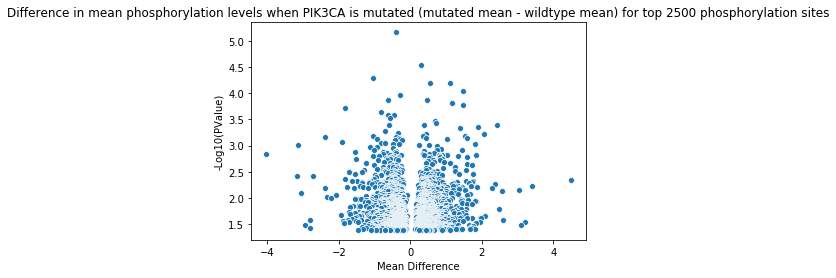

In [10]:
ax = sns.scatterplot(x = "Mean Difference", y = "-Log10(PValue)", data =df)
ax.set_title("Difference in mean phosphorylation levels when PIK3CA is mutated (mutated mean - wildtype mean) for top " + str(len(pvals)) + " phosphorylation sites")